In [2]:
import lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Overview

Survival analysis is to analyze the effec of different risk factors and use them to predict the duration of time between one event (birth) and another (death). It was first developed to predict how long individuals would survive. However, it has expanded into many different applications.

In the general sense, it can be thought of as a way to model anything with a finite duration - retention, churn, completion...
Here are the definition of "birth" and "death" and a few examples:

    - birth are events that marks the beginning of the time period for observation.
    - death are the occurring of the event of interest, which marks the end of the observation period.
    
    Example: customer churn      Birth Event: customer subscribes to a service      Death Event: customer leaves
             employee retention               employee is hired                                  employee quits
             part reliability                 part is in use                                     part fails
             program completion               begins PhD program                                 earns PhD
             response time                    call is made                                       police arrive
             

# Censorship in Data

When we havn't observe the "death" event for some subject, these observations are said to be censored. Suppose a new cancer treatment is developed. Researchers select 50 individuals for the study to undergo treatment and participate in post-treatment observation. During the study:

    1. Some subjects die during the course of study which would trigering their death event.
    2. Some subjects drop out, or the researchers lose contact with them. The researchers have their data up until some point,        but they don't have a death event to record.
    3. Some participants are still alive at the end of the observation period. So again, researchers have their data up until          some point, but there is no death event to record.

We could deal with censored data in two ways:

    1. We could just treat the end of the observtion period as the time of the death event.
    2. We could drop the censored data using the rationale that we have "incomplete data" for those observations

But, both will underestimate survival rates. 

# Hazard Function

The hazard function represents the instantaneous likelihood of failure. It can be treated as a PDF, and with real-world data, it comes in three typical shapes:

    - increasing failure rate
    - bathtub shaped
    - decreasing failure rate
    
Increasing and decreasing failure rate are fairly intuitive - the bathtub shaped is the most surprising. What the "bathtub" means is that - threats are highest at youth, but then decrease and stabilize at maturity, only to eventually re-emerge in old age. 

# Survival Function

As you can see they all start at 1 for time 0 - at the beginning, all things are alive. Then they all move down over time to eventually approach and converge to 0.

Key components for survival analysis:

    - Kaplan Meier Estimator
    - Nelson Aalen Estimator
    - Proportional Hazards (Cox Model, integrates covariate)
    - Additive Hazards Model (Aalen's Additive Model, when covariates are time-dependent)
    
Note that we can use any Pandas DataFrame with lifelines, but we must have features for:

    - a duration of time for the observation
    - a binary column regarding censorthip (1 if the death event was observed, 0 if the death event was not observed)
    
Sometimes, we will have to engineer these features. How might we go about that?

# Example 1: Leukemia

lifelines comes with some datasets to get us started. Most of the datasets are cleaned-up versions of real datasets. Here we will use the Leukemia dataset comparing 2 different treatments.

In [3]:
from lifelines.datasets import load_leukemia

leukemia = load_leukemia()
leukemia.head()

,t,status,sex,logWBC,Rx
0,35,0,1,1.45,0
1,34,0,1,1.47,0
2,32,0,1,2.20,0
3,32,0,1,2.53,0
4,25,0,1,1.78,0


In [4]:
leukemia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
t         42 non-null int64
status    42 non-null int64
sex       42 non-null int64
logWBC    42 non-null float64
Rx        42 non-null int64
dtypes: float64(1), int64(4)
memory usage: 1.7 KB


In [5]:
leukemia.describe()

,t,status,sex,logWBC,Rx
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,12.880952,0.714286,0.476190,2.930238,0.500000
std,9.347498,0.457230,0.505487,0.917522,0.506061
min,1.000000,0.000000,0.000000,1.450000,0.000000
25%,6.000000,0.000000,0.000000,2.302500,0.000000
50%,10.500000,1.000000,0.000000,2.800000,0.500000
75%,18.500000,1.000000,1.000000,3.490000,1.000000
max,35.000000,1.000000,1.000000,5.000000,1.000000


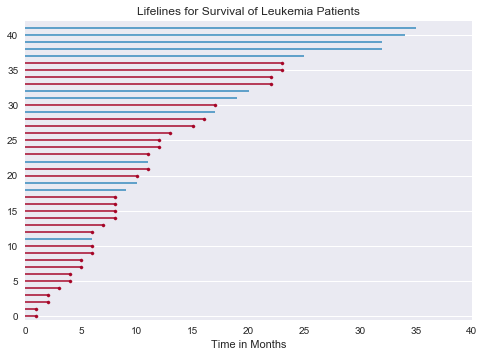

In [6]:
durations = leukemia.t.values
events = leukemia.status.values

ax = lifelines.plotting.plot_lifetimes(durations=durations,event_observed=events)
ax.set_xlim(0, 40)
ax.grid(axis='x')
ax.set_xlabel("Time in Months")
ax.set_title("Lifelines for Survival of Leukemia Patients");
plt.plot();

In [10]:
leukemia.status
leukemia.t

0     35
1     34
2     32
3     32
4     25
5     23
6     22
7     20
8     19
9     17
10    16
11    13
12    11
13    10
14    10
15     9
16     7
17     6
18     6
19     6
20     6
21    23
22    22
23    17
24    15
25    12
26    12
27    11
28    11
29     8
30     8
31     8
32     8
33     5
34     5
35     4
36     4
37     3
38     2
39     2
40     1
41     1
Name: t, dtype: int64

# Kaplan-Meier survival estimate

The Kaplan-Meier method estimates survival probability from observed survival times. It results in a step function that changes value only at the time of each event, and confidence intervals can be computed for the survival probabilities.

The KM survival curve, a plot of KM survival probability against time, provide a useful summary of the data. It can be used to estimate measures such as median survival time.

It cannot account for risk factors and is not regression. It is non-parametric (does not involve parameters).

However, it is a good way to visualize a survival dataset, and can be useful to compare the effects of a single catgorical variable.

Median Survival: 12.0 months after treatment


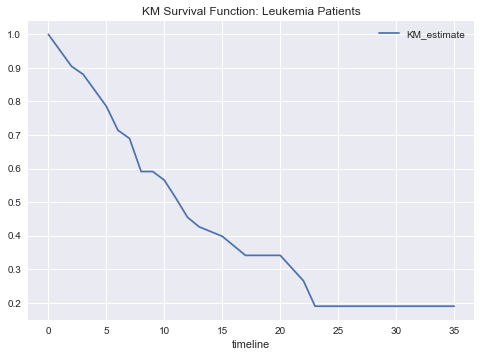

In [12]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(durations, events)

kmf.survival_function_.plot.line()
#kmf.survival_function_.plot()
plt.title('KM Survival Function: Leukemia Patients');
print(f'Median Survival: {kmf.median_} months after treatment')

Median survival time with Treatment 1: 8.0 months
Median survival time with Treatment 0: 23.0 months


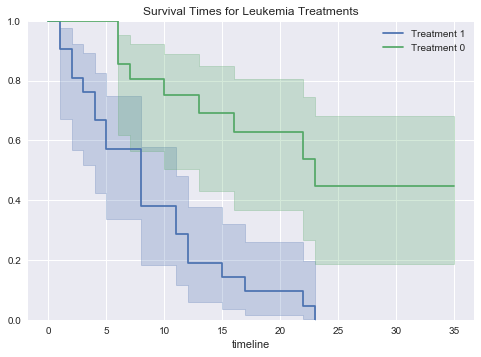

In [13]:
# compare the effects of a single categorical variable, RX
ax = plt.subplot(111)

treatment = (leukemia['Rx'] == 1)
kmf.fit(durations[treatment],events[treatment],label="Treatment 1")
kmf.plot(ax=ax)
print(f'Median survival time with Treatment 1: {kmf.median_} months')

kmf.fit(durations[~treatment],events[~treatment],label="Treatment 0")
kmf.plot(ax=ax)
print(f'Median survival time with Treatment 0: {kmf.median_} months')

plt.ylim(0, 1);
plt.title("Survival Times for Leukemia Treatments");

# Cox Proportional Hazards Model -- Survival Regression